In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from common import fetch_data, get_backtest_result, get_hodl_result, max_drawdown, get_cache_path, save_cache_data, load_cache_data, sharpe_ratio, load_volume_data

In [3]:
# Input
exchanges_markets = [
    {
        "binance": "BTCUSDT",
        "bitmex": "XBTUSD",
        "apollox": "BTCUSDT",
        "drift": "BTC-PERP"
    },
    {
        "binance": "ETHUSDT",
        "bitmex": "ETHUSD",
        "apollox": "ETHUSDT",
        "drift": "ETH-PERP"
    },
    {
        "binance": "SOLUSDT",
        "bitmex": "SOLUSD",
        "apollox": "SOLUSDT",
        "drift": "SOL-PERP"
    },
    {
        "binance": "XRPUSDT",
        "bitmex": "XRPUSD",
        "apollox": "XRPUSDT",
        "drift": "XRP-PERP"
    },
    {
        "binance": "BNBUSDT",
        "bitmex": "BNBUSD",
        "apollox": "BNBUSDT",
        "drift": "BNB-PERP"
    },
]

# Initial variables
min_time = datetime.fromisoformat('2023-08-01').timestamp()
max_time = datetime.fromisoformat('2024-02-29').timestamp()

data_df_map = {}
results = {}

leverage = 1

# Read data from file
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        data_df = load_cache_data(exchange, market)
        
        if exchange not in data_df_map:
            data_df_map[exchange] = {}
        data_df_map[exchange][market] = data_df

# calculate min max time
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        data_df = data_df_map[exchange][market]
        min_time = max(min_time, data_df["timestamp"].min())
        max_time = min(max_time, data_df["timestamp"].max())

# Calculate funding rate backtest result
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        data_df = data_df_map[exchange][market]
        data_df['datetime'] = data_df['datetime'].apply(lambda x: pd.to_datetime(x))

        data_df = data_df[
            (data_df["timestamp"] >= min_time) & (data_df["timestamp"] <= max_time)
        ]

        data_df = data_df.sort_values(by='datetime', ascending=True)
        data_df = data_df.reset_index(drop=True)

        result_df = get_backtest_result(data_df, leverage)
        
        if exchange not in results:
            results[exchange] = {}
            
        results[exchange][market] = result_df

# Results are store in 'results' variables

In [4]:
# Volume data
vol_data = load_volume_data()

data = []

for exchange, market_data in vol_data.items():
    for market, vol in market_data.items():
        data.append({
            "market": market,
            "exchange": exchange,
            "vol": vol,
            "pnl": results[exchange][market]['final_pnl'].iloc[-1]
        })
        
df_vol = pd.DataFrame(data)

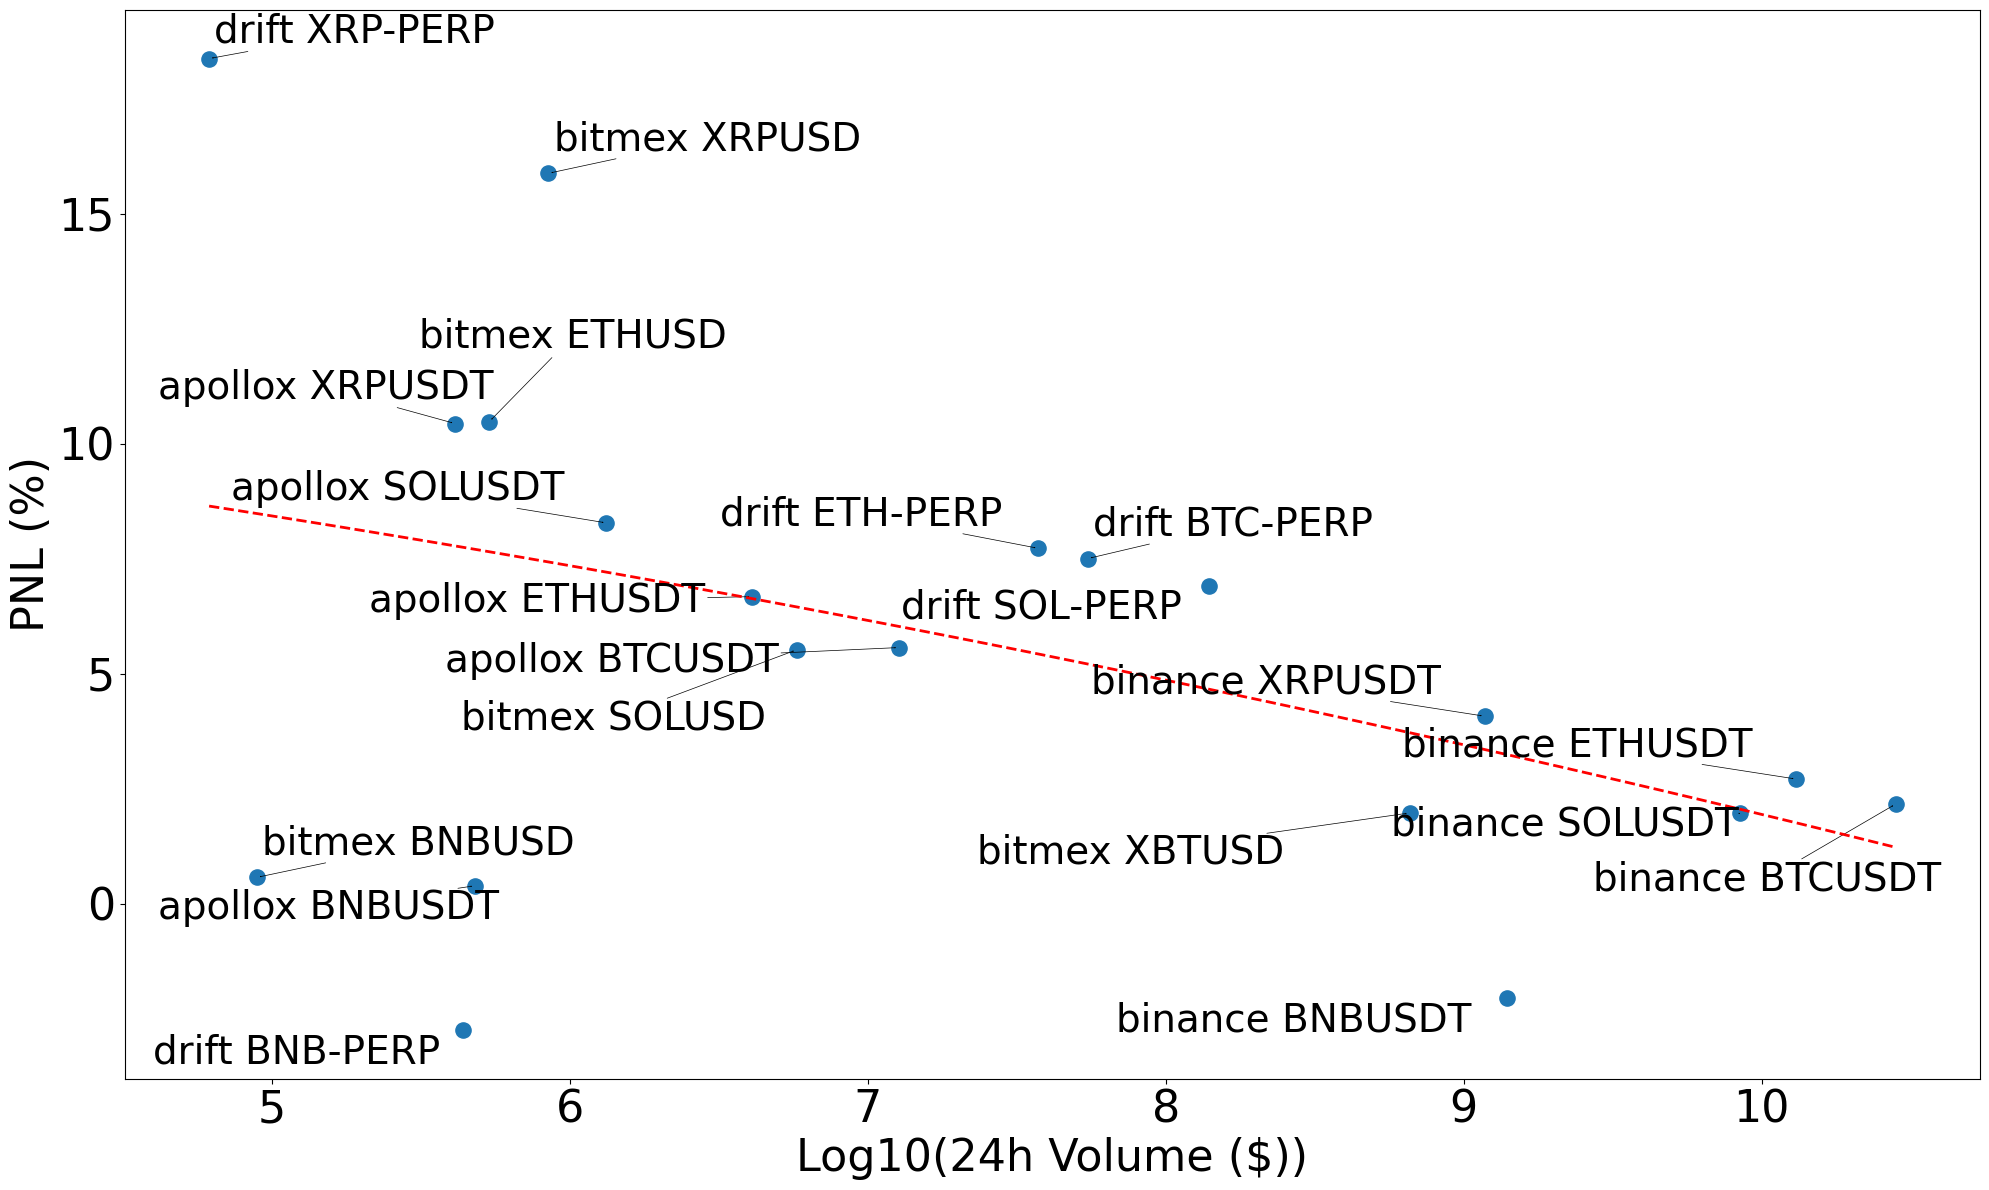

In [16]:
from adjustText import adjust_text
import numpy as np

# Plot funding rate arb PNL only
annotated_points = [] 

x = np.log10(df_vol['vol'])
y = df_vol['pnl'] * 100

# Fit a polynomial regression curve, degree 2 for a parabolic curve
degree = 2
coefficients = np.polyfit(x, y, degree)
polynomial = np.poly1d(coefficients)
x_line = np.linspace(min(x), max(x), 100)
y_line = polynomial(x_line)

# Plot
fig, ax = plt.subplots(figsize=(20, 12))
plt.scatter(x, y, s=120)
plt.plot(x_line, y_line, color='red', linewidth=2, linestyle="--")

# Add text labels
texts = []

for index, row in enumerate(df_vol.iterrows()):
    row_item = df_vol.loc[index]
    vol_item = x.iloc[index]
    pnl_item = row_item['pnl']
    market_item = row_item['market']
    exchange_item = row_item['exchange']
    if (vol_item, pnl_item * 100) not in annotated_points:  # Check if point already annotated
        annotation_text = f"{exchange_item} {market_item}"
        texts.append(ax.annotate(annotation_text, (vol_item, pnl_item * 100),
                                    fontsize=28, ha='center'))

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=0.5))

# Chart settings
plt.xlabel("Log10(24h Volume ($))", fontsize=32)
plt.ylabel("PNL (%)", fontsize=32)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

# Ensure a tight layout to avoid label/legend clipping
plt.tight_layout()

plt.savefig('./images/market_size_pnl.png', format='png', dpi=300, bbox_inches='tight')

plt.show()